# Random Sampling using SciPy and NumPy: Part III

## Implementing custom distribution sampling in SciPy

In the previous two parts ([Part I](https://towardsdatascience.com/random-sampling-using-scipy-and-numpy-part-i-f3ce8c78812e), [Part II](https://towardsdatascience.com/random-sampling-with-scipy-and-numpy-part-ii-234c2385828a)) we walked through a quick intro to what sampling entails as well as then digging through the source code of NumPy and SciPy to understand exactly how this is implemented in modern python libraries.

All of this can seem like overkill when usually we don't care about the underlying process - we're very happy for that mental gymnastics to be handled by cleverly constructed imported libraries and leave us to focus on utilising the output for more insightful tasks (like Monte Carlo simulation).

However there are times when we encounter a use case that is not quite catered for by the standard libraries. The following is one such case and provides an example where understanding both:
 - the theoretical ideas behind sampling (particularly Inverse Transform Sampling)
 - the programatic implementation of such sampling processes

can make the difference between an unworkably slow implementation and one that can almost rival the optimised work of the clever people behind NumPy and SciPy.

## Why would I need to sample from a custom distribution?

On many occasions. Whilst in a Normal world (pardon the pun) it is the default to do something along the lines of:
 - gather data and plot histogram
 - conclude that the data is roughly normal (i.e. bell shaped)
 - fit an appropriate normal distribution and be done with it

there are circumstances where this doesn't quite cut it. The following is my particular case but can be generalised to any setting where a pre-packaged distribution, no matter how well parameterised, isn't going to be good enough.

## 'Variance preserving tail fattening'

It sounds much fancier than it is. [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is defined by the following equation:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

In simple terms, the change in the value of our process, `S`, over some time increment `dt` is comprised of two parts:
 - some constant deterministic drift term
 - some stochastic term

Importantly, GBM is characterised by that stochastic element being normally distributed - the `dW` element is called a [Wiener Process](https://en.wikipedia.org/wiki/Wiener_process) or more commonly a 'random walk'. My problem is the following - I want to simulate a load of these 'stochastic paths' but I don't want to sample my stochastic change from a normal distribution.

Instead, I want to create my own 'custom' distribution - in particular I want a variance preserving transform (i.e. the variance still being `1` like the standard normal) but the distribution has juicy fat tails (excess kurtosis). The question then becomes:

## How can I do this within the SciPy/NumPy framework?

Before getting into this, let's first have a quick look at the difference between the pdfs of:
 - the standard normal distribution
 - the distribution I wish to sample from

To create the fat-tailed distribution I want I'll be making use of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality). In particular I'll be making use of the fact that if we take the average density of 2 normal distributions with an average variance of `1` then we will get a distribution with a 'taller body' and 'fatter tails' i.e. more kurtosis, but still maintain a variance of `1` like the standard normal.

To be even clearer, our fat tailed distribution will be the pdf given by averaging:
 - a normal distribution with variance `1 + e`
 - a normal distribution with variance `1 - e`

where `e` is bounded between `[0,1]`. Let's plot this so we can see how these distributions look as we vary `e` in comparison to the standard normal distribution.

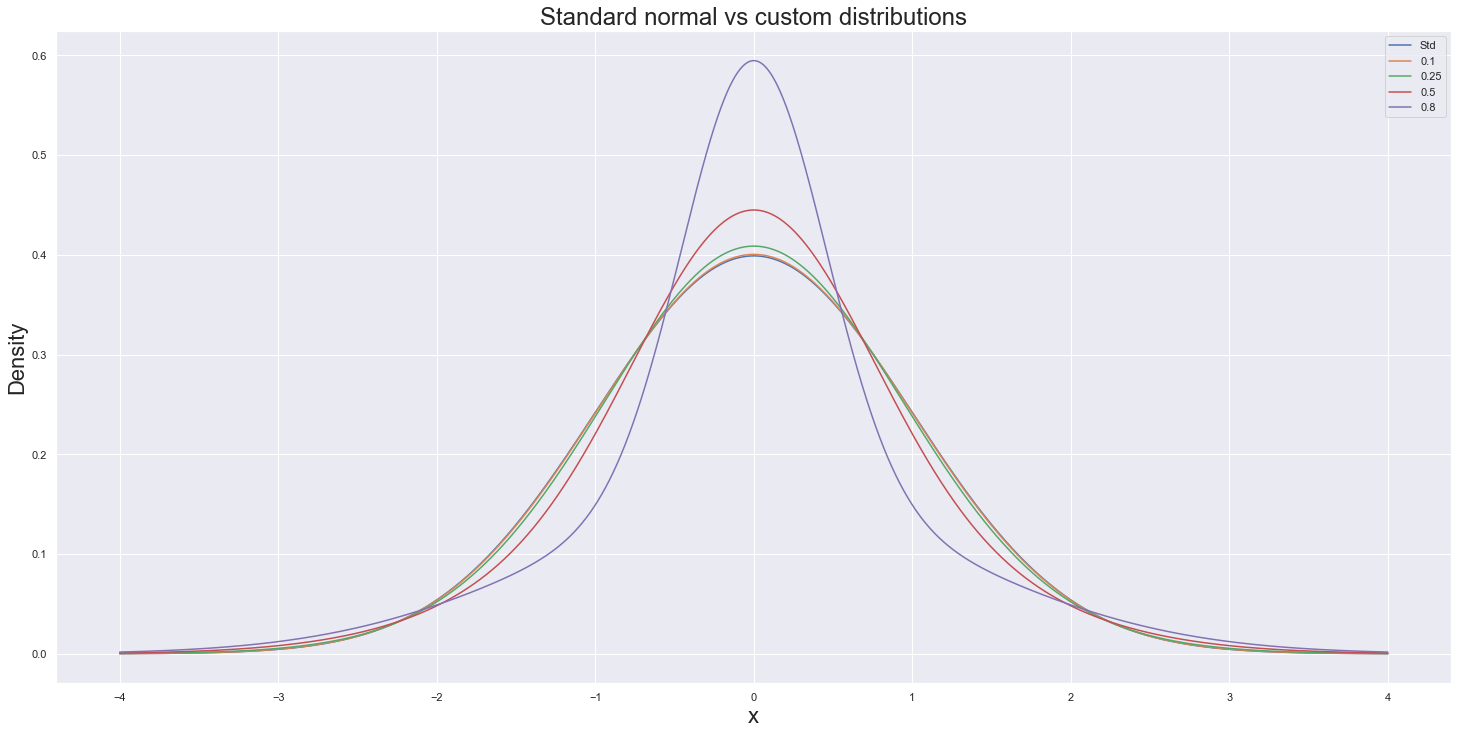

In [3]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

from scipy.integrate import simps
from scipy.interpolate import interp1d

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

# this is the 1d domain over which our pdf exists
xs = np.linspace(-4.0, 4.0, 10000)

# define normal pdf
def norm_p(x, mu=0, sigma=1):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-0.5 * ((x - mu)**2 / sigma**2))

# define our custom pdf as the average of normals
def p(x, mu=0, sigma=1, sigma_dev=0):
    low = norm_p(x, mu, sigma * (1 - sigma_dev)**0.5)
    high = norm_p(x, mu, sigma * (1 + sigma_dev)**0.5)
    return 0.5 * (low + high)

# define our params
mu = 0
sigma = 1
devs = [0.1, 0.25, 0.5, 0.8]
pdfs = {'Std': [norm_p(x) for x in xs]}

# compute pdfs of our custom dist with various varince deviations
for d in devs:
    pdf = [p(x, sigma_dev=d) for x in xs]
    pdfs[d] = pdf

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
for label, pdf in pdfs.items():
    ax.plot(xs, pdf, label=label)

    # label them
ax.legend()
ax.set_title('Standard normal vs custom distributions', fontsize=24)
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('Density', fontsize=22);

So as mentioned, our averaged distributions display taller bodies and fatter tails. In particular we see that all the custom distributions cross over the standard normal distributions at almost the same points - around +/-0.66 for the shoulders and +/-2.13 for the tails. In fact, we can use this as a feature to define what part of a probability distribution we actually refer to when we talk about 'the tails' rather than just having an abstract notion.

More technically, the tails are defined by the density of a probability distribution that is convex variance. In simple terms, the density outside of +/-2.13 has increased in the distributions above once we have made the variance vary (instead of being a constant `1`).

This slots in nicely with the idea usually bandied around about how fat tailed a distribution is being related to the kurtosis - because kurtosis is just the fourth moment or, in other words, the variance of variance. Alter the variance (through our distribution averaging above) and we start getting fatter tailed resulting pdfs.

Now we know what distribution we are trying to implement, let's implement it.

## Attempt 1: Simple, naive but slow (really slow)

Despite this approach being so slow to render it not really a solution at all, it's still quite something that SciPy has all this functionality built in. The approach is this:
 - create a custom distribution class that inherits from the `rv_continuous` SciPy class
 - just define the `_pdf` method that reflects the custom distribution pdf we are after
 - SciPy does everything else to allow us to sample from this custom distribution

For a quick review of what the `rv_continuous` class is or the distribution structure of SciPy in general then maybe best to [skip back to Part II](https://towardsdatascience.com/random-sampling-with-scipy-and-numpy-part-ii-234c2385828a) for a quick reminder of how `rv_continuous` inherits from `rv_generic`. Otherwise, let's continue on and write our naive implementation, `naive_cust_dist`:

In [4]:
# define our custom distribution
class naive_cust_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
    
    # function to return normal distribution pdf
    def norm_p(self, x, loc=0, scale=1):
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
        
    # pdf function for averaged normals
    def _pdf(self, x):
        # define lower var distribution prob
        low = self.norm_p(x, scale=(1 - self.e)**0.5)
        # define higher var distribution prob
        high = self.norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)

Now we have it defined let's do 2 things:
 - draw samples from it and check if the histogram we generate from those samples is congruent with our defined pdf
 - speed test how long it takes us to draw those samples and compare to SciPy's embedded normal distribution sampling

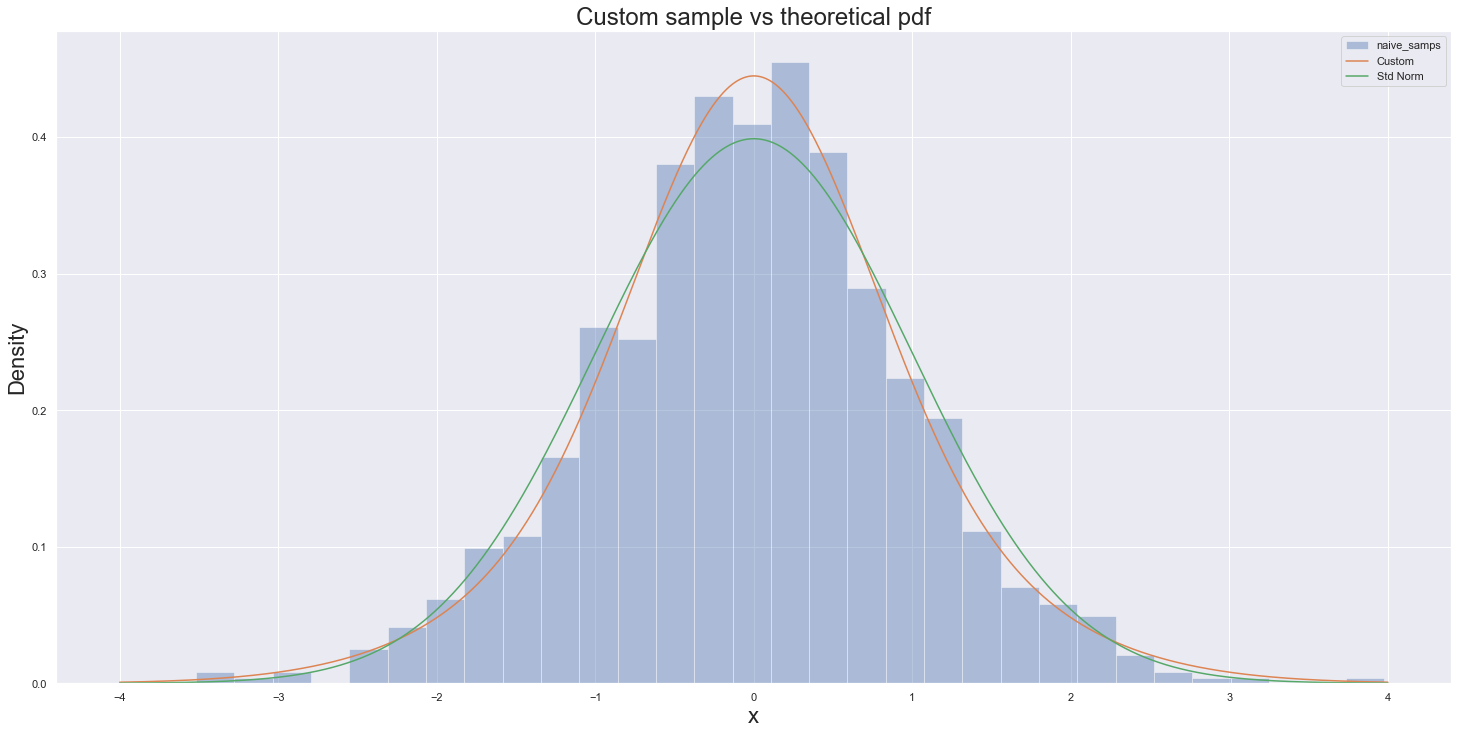

In [12]:
# define instance of dist
naive_dist = naive_cust_dist(e=0.5)
# draw samples
n = 1000
naive_samps = naive_dist.rvs(size=n)

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
# plot hist and pdf to see if they aline
sns.distplot(naive_samps, label='naive_samps', kde=False, norm_hist=True, ax=ax)
ax.plot(xs, pdfs[0.5], label='Custom')
# plot standard normal for comparison
ax.plot(xs, pdfs['Std'], label='Std Norm')
ax.legend()
# label
ax.set_title('Custom sample vs theoretical pdf', fontsize=24)
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('Density', fontsize=22);

The above shows the resulting histogram from sampling `1,000` numbers from our custom class `naive_cust_dist` that implements the pdf we wish to sample from. As we can see the histogram largely lines up with the theoretical pdf (the green line) and that this is markedly different from the plotted standard normal pdf.

So in theory, that's it. We've implemented custom sampling with only defining the `_pdf` method and SciPy has done the rest.

## What's 'the rest'?

As mentioned in Part I, there are many different ways to sample from a distribution. However, none of them take as input solely the pdf and use that to generate random numbers which if we were to plot them as a histogram (like above) we would recover the same pdf. Instead we need either:
 - a clever algorithm (e.g. rejection sampling algorithms like the Ziggurat algorithm)
 - the inverse cumulative distribution function (cdf) to make use of inverse transform sampling

Algorithms can be distribution specific and when it comes to implementing a custom distribution SciPy uses inverse transform sampling which requires the latter: the inverse cdf. As a result, 'the rest' comprises of:
 - computing the `_cdf` from the given `_pdf`
 - computing the `_ppf` (the name SciPy gives to the inverse cdf - the 'percentage point function') from the cdf
 - using that `_ppf` function to churn out samples by using a PRNG to generate uniformly distributed random numbers and use inverse transform sampling

The problem is the following:

## Doing 'the rest' is prohibitively slow

The following shows just how slow - to compute a mere `1,000` samples from our custom distribution it takes more than `30s`.

In [13]:
%timeit naive_dist.rvs(size=n)

32.6 s ± 4.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can compare that to sampling `1,000` numbers from the normal distribution using SciPy.

In [41]:
%timeit stats.norm.rvs(size=n)

168 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


So to be clear, we are almost `200,000x` slower than the built in SciPy sampling method. However it's not just the relative nature of how slow it is that is problematic - in absolute terms taking `30s` to sample only `1,000` numbers is not workable especially if we want to do something like sample `10,000` paths with each path consisting of `1,000` steps. We can't wait `3.5` days every time we want to run a simulation.

## Why is it so slow?

Just before using what we've learned from Part I and II to create a better solution, let's quickly tie out why the built in SciPy functionality is so slow. To answer this we need to dig through the SciPy source code to find the `_ppf` method - in particular the `_ppf_single` method it calls (named as such as SciPy like NumPy is vectorised to facilitate fast computation of sets of numbers). Below is the code snippet but you can go [here](https://github.com/scipy/scipy/blob/ced4d67ec8bfd7e25e5087c7dedc53bd8bd632d0/scipy/stats/_distn_infrastructure.py#L2002) if you fancy reading through the github source code yourself:

In [49]:
def _ppf_single(self, q, *args):
    factor = 10.
    left, right = self._get_support(*args)

    if np.isinf(left):
        left = min(-factor, right)
        while self._ppf_to_solve(left, q, *args) > 0.:
            left, right = left * factor, left
        # left is now such that cdf(left) <= q
        # if right has changed, then cdf(right) > q

    if np.isinf(right):
        right = max(factor, left)
        while self._ppf_to_solve(right, q, *args) < 0.:
            left, right = right, right * factor
        # right is now such that cdf(right) >= q

    return optimize.brentq(self._ppf_to_solve,
                           left, right, args=(q,)+args, xtol=self.xtol)

In words, the above is an implementation of inverse transform sampling that utilises a root finding algorithm ([Brent's Method](https://en.wikipedia.org/wiki/Brent%27s_method)) to convert a given random number, `q`, from a uniform distribution to a number from our chosen custom distribution. Even without going into the nitty gritty of the algorithm the fact that this process requires:
 - two `while` loops
 - a numerical integration function

should indicate that the speed of such a function is likely to be lacking. Instead, we want to circumvent this process and implement our own `_ppf`. In other words, let's take the inverse cdf that we created in Part I and slot it into the SciPy distribution framework.

## Attempt 2: A workable solution

So we'll return to creating our own distribution class inheriting from the generic `rv_continuous` class in SciPy. However, instead of just defining a `_pdf` method, let's also define a `_ppf` method.

How? We'll implement the inverse transform sampling approach we did in Part I. This means when we instantiate our class we need to do a bit more work. More specifically, we need to create the `ppf` by:
 - first creating the `cdf` by cumulative summing over the `pdf`
 - using SciPy's built in `interp1d` function to invert this and end up with our inverse `cdf`

Once we have that then we can set that as our `_ppf` method to prevent SciPy conducting the mathematical gymnastics from Approach 1 that made it unworkably slow.

In [69]:
# define our gaussian look-a-like distribution
class cust_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # init our variance divergence
        self.e = e
        # init our cdf and ppf functions
        self.cdf_func, self.ppf_func = self.create_cdf_ppf()
        
    # function to return normal distribution pdf
    def norm_p(self, x, loc=0, scale=1):
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
        
    # function to normalise the pdf over chosen domain
    def normalisation(self, x):
        return simps(self.pdf(x), x)
    
    # function to
    def create_cdf_ppf(self):
        # define domain as +/-25 sigma
        xs = np.linspace(-25, 25, 10000001)
        # normalise our pdf to sum to 1 so it satisfies a distribution
        norm_constant = self.normalisation(xs)
        # compute pdfs to be summed to form cdf
        my_pdfs = self.pdf(xs) / norm_constant
        # cumsum to form cdf
        my_cdf = np.cumsum(my_pdfs)
        # make sure cdf bounded on [0,1]
        my_cdf = my_cdf / my_cdf[-1]
        # create cdf and ppf
        func_cdf = interp1d(xs, my_cdf)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
        
    # pdf function for averaged normals
    def _pdf(self, x):
        # define lower var distribution prob
        low = self.norm_p(x, scale=(1 - self.e)**0.5)
        # define higher var distribution prob
        high = self.norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    # cdf function
    def _cdf(self, x):
        return self.cdf_func(x)
    
    # inverse cdf function
    def _ppf(self, x):
        return self.ppf_func(x)

Now we have it defined, let's try it out. Just as before let's check to see if it generates samples that are congruent with our defined `pdf` and then we can check to see if we've got a workable solution speed-wise.

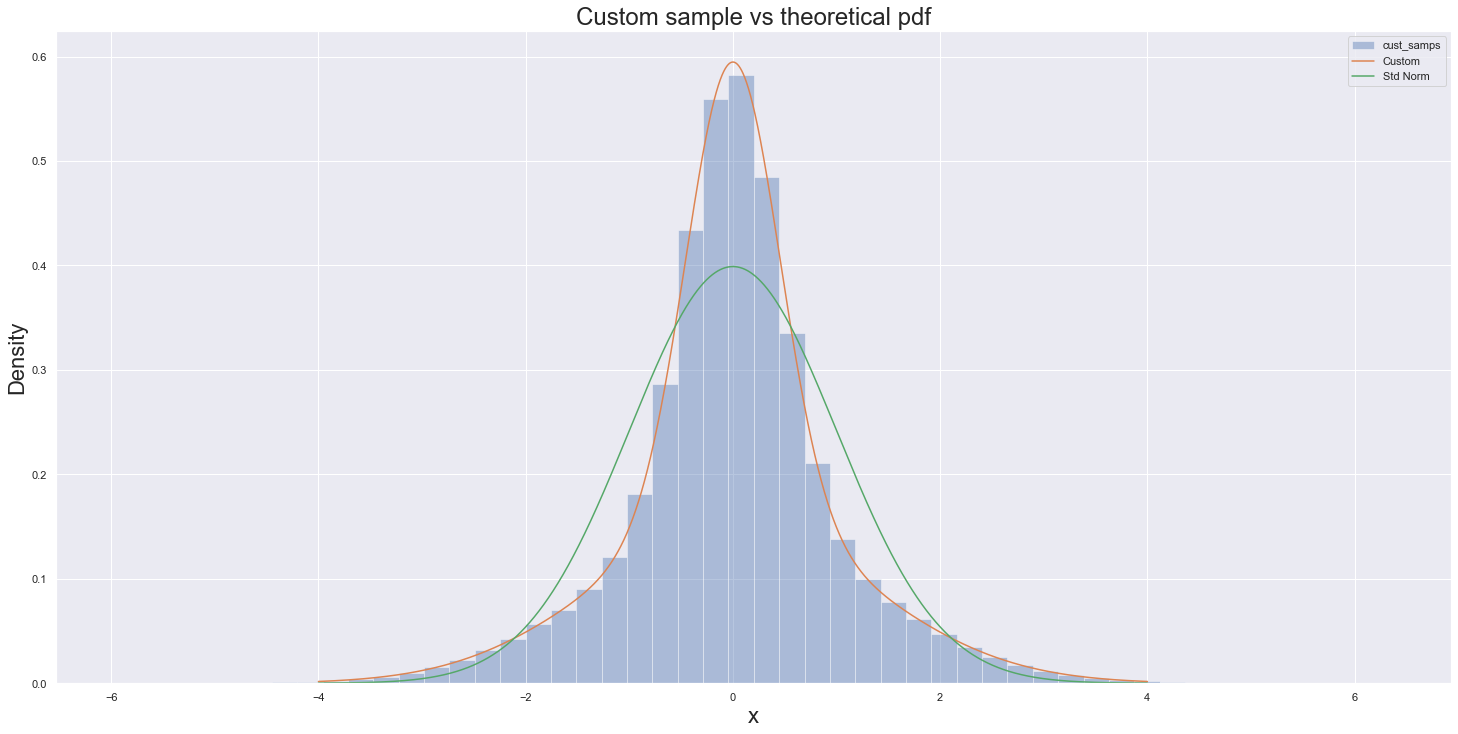

In [79]:
# define dist
my_dist = cust_dist(0.8)
# create samples
n = 1000000
cust_samps = my_dist.rvs(size=n)

# plot histogram
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
# plot hist and pdf to see if they aline
sns.distplot(cust_samps, label='cust_samps', kde=False, norm_hist=True, ax=ax)
ax.plot(xs, pdfs[0.8], label='Custom')
# plot standard normal for comparison
ax.plot(xs, pdfs['Std'], label='Std Norm')
ax.legend()
# label
ax.set_title('Custom sample vs theoretical pdf', fontsize=24)
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('Density', fontsize=22);

So once again we seem to have achieved the desired sampling distribution. Let's now check to see if the extra code and complexity was worth it in terms of speeding things up.

In [83]:
%timeit my_dist.rvs(size=1000)

1.84 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [84]:
%timeit stats.norm.rvs(size=1000)

116 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [87]:
%timeit my_dist.rvs(size=10000000)

12.8 s ± 1.62 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we're still much slower than SciPy (around `15x`) but that's a huge improvement over our previous `200,00x` approach. We now have a solution that can churn out `10,000,000` random numbers in little over `15s` - a much more reasonable time compared to the `3.5` days we had achieved previously.

## Conclusion

SciPy provides an extensive range of packaged distributions that provide rapid sampling. This sampling is distribution specific and written to make use of the speed of C, optimised python code and the most efficient sampling procedures. Whilst this is an invaluable resource that in most cases will provide a sufficient solution, there are indeed times where custom distribution sampling is required.

Having a deeper knowledge of the distribution architecture of SciPy, and specifically how this relies on NumPy, as shown above can make the difference between an accurate yet unworkably slow solution and one that isn't far off the blazing fast implementation of SciPy.